# Кейс: Найди инвестора (Сбер)
**Описание:**

Банк запустил линейку инновационных вложений - от метавселенной до NFT-котов. Проинвестировав в новые продукты, можно неплохо заработать, но не каждый клиент готов рискнуть.

**Задача** - предсказать, откликнется ли клиент на предложение банка вложить средства в инвестиционный продукт. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных

In [37]:
X_private_test = pd.read_csv('../data/invest_test_private.csv', sep=',', index_col=0)
X_public_test = pd.read_csv('../data/invest_test_public.csv', sep=',', index_col=0)
data = pd.read_csv('../data/invest_train.csv', sep=',', index_col=0)
sub_sample = pd.read_csv('../data/sample_submission.csv', sep=',')

## Информация о датасете
- invest_train.csv - обучающая выборка;
- invest_test_public.csv - открытая тестовая выборка;
- sample_submission.csv - пример предсказаний.

Признаки объектов:
- customer_id - уникальный идентификатор клиента, целочисленное значение;
- age - возраст клиента, целочисленное значение;
- balance - баланс клиента, число с плавающей точкой;
- risk_profile - профиль риска клиента, оценка его отношения к риску, категориальный признак, принимает значения “low”, “medium”, “high”;
- marketing_channel - канал, по которому связываются с клиентом, категориальный признак, принимает значения “phone”, “in_branch”, “sms”, “email”;
- offer_amount - сумма, которую предлагается вложить клиенту, целочисленное значение;
- previous_investments - делал ли клиент вложения ранее, целочисленный бинарный признак;
- responded_before - отвечал ли клиент ранее, целочисленный бинарный признак;
- membership_tier - уровень привилегий клиента, категориальный признак, принимает значения “standard”, “gold”, “platinum”.

In [22]:
data

,age,balance,risk_profile,marketing_channel,offer_amount,previous_investments,responded_before,membership_tier,accepted
customer_id,,,,,,,,,
0,75,199122.20,low,phone,79471,0,0,platinum,0
1,72,182826.57,high,in_branch,59413,1,1,gold,1
2,82,119785.23,high,sms,33092,1,1,gold,1
3,23,320109.79,high,sms,34806,1,0,standard,0
4,68,166134.85,low,email,66491,0,0,standard,0
...,...,...,...,...,...,...,...,...,...
5995,73,107771.18,low,sms,39293,1,0,gold,1
5996,71,443467.72,low,sms,53386,1,0,gold,1
5997,60,36070.24,low,in_branch,90885,1,0,gold,1


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_id           6000 non-null   int64  
 1   age                   6000 non-null   int64  
 2   balance               6000 non-null   float64
 3   risk_profile          6000 non-null   object 
 4   marketing_channel     6000 non-null   object 
 5   offer_amount          6000 non-null   int64  
 6   previous_investments  6000 non-null   int64  
 7   responded_before      6000 non-null   int64  
 8   membership_tier       6000 non-null   object 
 9   accepted              6000 non-null   int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 468.9+ KB


In [18]:
data.isnull().sum()

customer_id             0
age                     0
balance                 0
risk_profile            0
marketing_channel       0
offer_amount            0
previous_investments    0
responded_before        0
membership_tier         0
accepted                0
dtype: int64

In [25]:
data.nunique()

age                       72
balance                 5998
risk_profile               3
marketing_channel          4
offer_amount            5791
previous_investments       2
responded_before           2
membership_tier            3
accepted                   2
dtype: int64

# EDA

## Числовые признаки

In [69]:
numeric_columns = ['age', 'balance', 'offer_amount']

In [29]:
data[numeric_columns].describe()

,age,balance,offer_amount
count,6000.000000,6000.000000,6000.000000
mean,53.256833,251402.467837,52765.267500
std,20.733576,146629.547942,27536.358643
min,18.000000,25.380000,5001.000000
25%,35.000000,125036.747500,29083.750000
50%,54.000000,250333.235000,53043.500000
75%,71.000000,381066.040000,76592.250000
max,89.000000,499922.130000,99974.000000


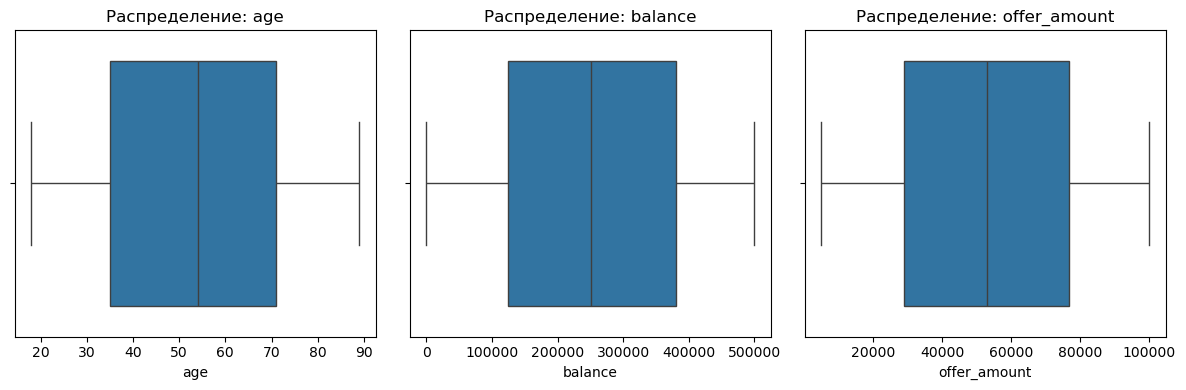

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, col in enumerate(numeric_columns):
    sns.boxplot(data=data, x=col, ax=axes[i])

    axes[i].set_title(f'Распределение: {col}')

plt.tight_layout()
plt.show()

<Axes: >

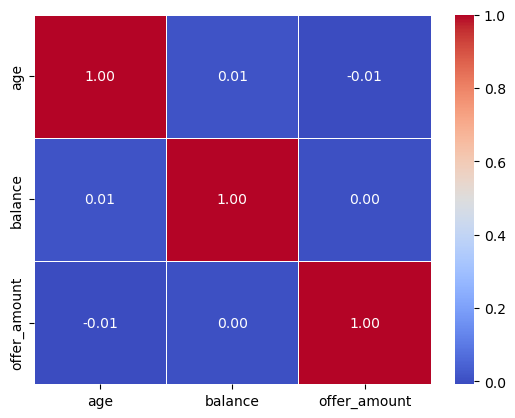

In [68]:
sns.heatmap(data[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

**Вывод:**
- Никакой корреляции и следовательно линейной зависимости между числовыми признаками нет.
- Данные скорее всего были синтетитчески сгенерированы, boxplot графики выглядят идеально, нет выбросов, медиана ровно посередине, нет преобладающих категорий пользователей по балансу/предлагаемому офферу/возрасту.

### Вклад баланса клиента на отклик

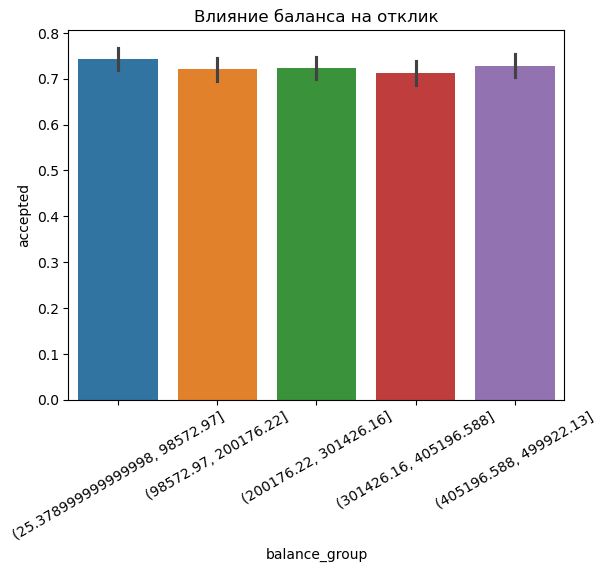

In [110]:
data['balance_group'] = pd.qcut(data['balance'], q=5)
sns.barplot(data=data, x='balance_group', y='accepted', hue='balance_group', legend=False)
plt.title('Влияние баланса на отклик')
plt.xticks(rotation=30)
plt.show()

**Вывод:**
- Баланс не оказывает почти никакого влияния на отлкик клиентов, необходимо рассматривать влияние категориальных признаков.

## Категориальные признаки

In [74]:
categorical_columns = data.drop(numeric_columns, axis=1).columns

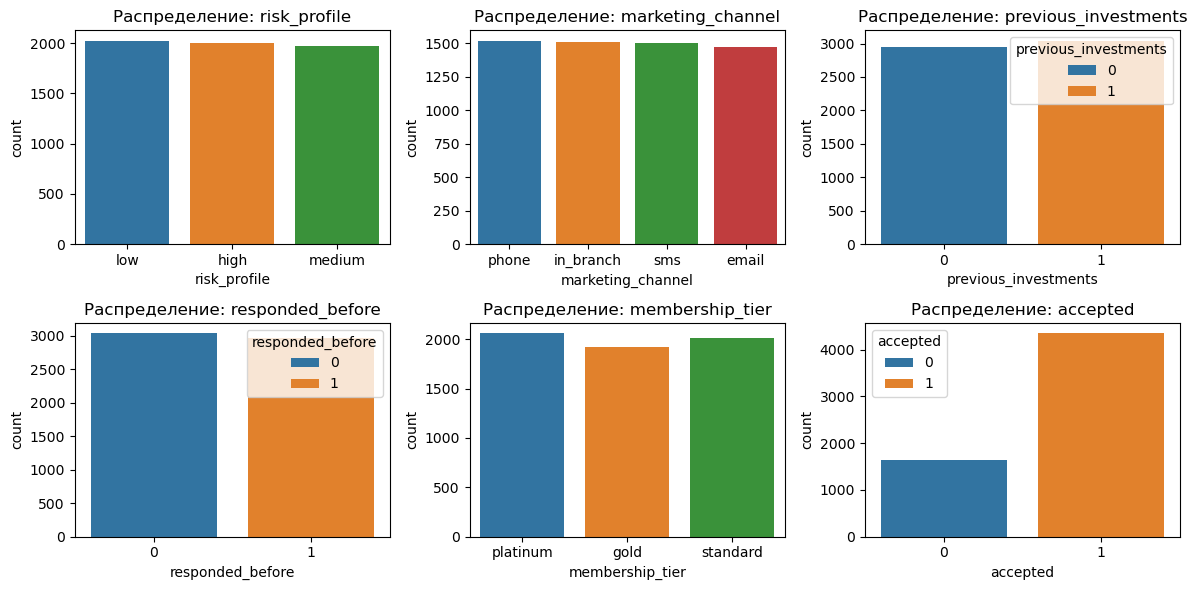

In [81]:
cols_num = 3
rows_num = 2
fig, axes = plt.subplots(rows_num, cols_num, figsize=(12, 6))

for i, col_name in enumerate(categorical_columns):
    row_index = i // cols_num
    col_index = i % cols_num
    sns.countplot(data=data, x=col_name, ax=axes[row_index, col_index], hue=col_name)

    axes[row_index, col_index].set_title(f'Распределение: {col_name}')

plt.tight_layout()
plt.show()

**Вывод:**
- Данные слишком идеальные и одинаковые для профиля риска клиента, каналам маркетинга, и типа привелегий.
- Необходимо проверить то, как различные признаки влияют на отклик клиента.

### Влияние признаков на отклик клиента

Text(0.5, 1.0, 'Влияние канала связи на отклик')

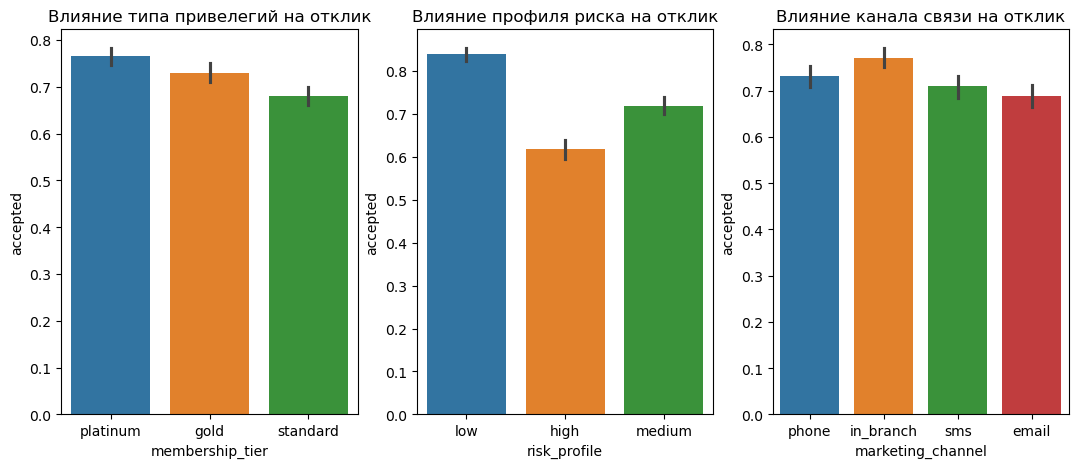

In [113]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5))

sns.barplot(data=data, x='membership_tier', y='accepted', ax=axes[0], hue='membership_tier')
axes[0].set_title(f'Влияние типа привелегий на отклик')

sns.barplot(data=data, x='risk_profile', y='accepted', ax=axes[1], hue='risk_profile')
axes[1].set_title(f'Влияние профиля риска на отклик')

sns.barplot(data=data, x='marketing_channel', y='accepted', ax=axes[2], hue='marketing_channel')
axes[2].set_title(f'Влияние канала связи на отклик')

Text(0.5, 1.0, 'Влияние предыдущего ответа на предложение')

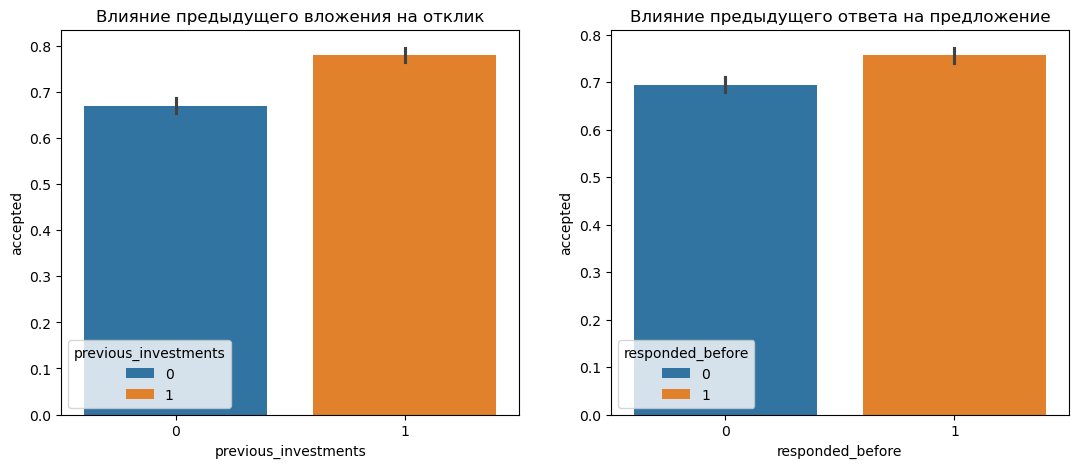

In [114]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

sns.barplot(data=data, x='previous_investments', y='accepted', ax=axes[0], hue='previous_investments')
axes[0].set_title(f'Влияние предыдущего вложения на отклик')

sns.barplot(data=data, x='responded_before', y='accepted', ax=axes[1], hue='responded_before')
axes[1].set_title(f'Влияние предыдущего ответа на предложение')

**Вывод:**
- Ключевое влияние на отклик клиента оказывает совокупность категориальным признаков.
- Наибольший вклад оказывает профиль риска, люди с высоким отношением к риску склонны отказываться от инвестиций в продукт.
- За ним следует предыдущий опыт в инвестициях, люди которые вкладывались в предыдущие продукты более лояльны к новым предложениям.
- Исходя из наблюдений лучшим выбором будут нелинейные молдели, которые хорошо выявляет сложные зависимости между признаками и совокупности ключевых категориальных признаков, также выбор в пользу нелинейных моделей отдается ввиду отсутствия явных линейных зависимостей числовых признаков.

# Data preprocessing

**Добавим новые признаки**:
- Уровень лояльности клиента - соответствует клиентам, которые ранее инвестировали в продукты и отвечали он ранее
- Риск по возрасту - комбинация демографического признака и профиля риска, может отражать паттерны поведения, молодые люди более снисходительны к риску, взрослые - менее.

In [6]:
def preprocess_data(data, is_train=True):
    data = data.copy()
    
    data['loyalty_score'] = data['previous_investments'] + data['responded_before']
    
    data['age_risk'] = data['age'].astype(str) + '_' + data['risk_profile']
    
    if is_train:
        y = data['accepted']
        X = data.drop('accepted', axis=1)
        return X, y
    else:
        return data

# Modeling

В качестве модели был выбран **CatBoostClassifier**, ввиду своей простоты работы с категориальными признаками.

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier, cv, Pool
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [8]:
# Загрузка + подготовка данных
data = pd.read_csv('../data/invest_train.csv', sep=',', index_col=0)

X, y = preprocess_data(data, is_train=True)

In [9]:
# Разбиваем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
# Выделим категориальные признаки
cat_features = ['risk_profile', 'marketing_channel', 'membership_tier', 'age_risk']

In [101]:
model = CatBoostClassifier(
    iterations=2000,
    loss_function='Logloss',
    eval_metric='F1',
    auto_class_weights='Balanced',
    cat_features=cat_features,
    verbose=False,
    early_stopping_rounds=50,
    random_state=42
)

In [21]:
params = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

**Используем для кросс валидации весь датасет**

In [27]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=params,
    cv=5,
    scoring='f1',
    refit=False
)

grid_search.fit(X, y)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший F1 score:", grid_search.best_score_)

Лучшие параметры: {'depth': 8, 'l2_leaf_reg': 3, 'learning_rate': 0.05}
Лучший F1 score: 0.8458503032767801


In [102]:
final_model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=3,
    loss_function='Logloss',
    eval_metric='F1',
    auto_class_weights='Balanced',
    cat_features=cat_features,
    verbose=False,
    random_state=42
)

**Обучаем на обучающей выборке**

In [74]:
final_model.fit(X_train, y_train)

In [91]:
y_pred = final_model.predict(X_test)

In [92]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()

,precision,recall,f1-score,support
0,0.598410,0.554328,0.575526,543.000000
1,0.836154,0.859429,0.847632,1437.000000
accuracy,0.775758,0.775758,0.775758,0.775758
macro avg,0.717282,0.706879,0.711579,1980.000000
weighted avg,0.770955,0.775758,0.773009,1980.000000


In [96]:
feature_importances = final_model.feature_importances_

In [97]:
feature_importances_df = pd.DataFrame(
    {
        "features" : list(X_train),
        "feature_importances" : feature_importances
    }
)

In [99]:
feature_importances_df.sort_values("feature_importances", ascending=False)

,features,feature_importances
9,age_risk,21.705129
4,offer_amount,15.965921
1,balance,11.756309
7,membership_tier,10.821452
3,marketing_channel,10.117720
0,age,9.981539
2,risk_profile,9.902245
5,previous_investments,3.754338
8,loyalty_score,3.189828
6,responded_before,2.805519


**Вывод:**
- Метрика **F1** на тестовом наборе составила **0.85**, что совпадает с результатом кросс валидации, модель обладает хорошей способностью определять потенциальных клиентов котовых инвестировать в продукт.
- Precision в **0.83** и Recall охватывает **0.86**. Данные метрики говорят о том, что наша модель совершает мало ложных срабатываний и успешно охватывает всех потенциальных инвесторов, данные показатели являются критически важными для данной задачи.
- Ключевыми признаками модели являются *Риск по возрасту*, *Сумма оффера*, *Баланс*.

# Тестовый датасет

**Финальный вариант модели обученной на всём датасете без разбиения** (его и будем использовать на public_test_data)

In [42]:
final_model.fit(X, y)

In [48]:
public_test_data = pd.read_csv('../data/invest_test_public.csv', sep=',', index_col=0)
public_test_data

,age,balance,risk_profile,marketing_channel,offer_amount,previous_investments,responded_before,membership_tier
customer_id,,,,,,,,
6000,69,435642.06,high,in_branch,39840,0,1,gold
6002,61,420608.92,low,email,64782,1,1,gold
6004,46,343381.85,high,in_branch,64184,1,0,standard
6006,19,204918.78,high,email,74869,1,1,gold
6008,82,117961.03,low,email,17763,0,0,gold
...,...,...,...,...,...,...,...,...
7990,86,237898.22,medium,phone,43216,0,0,standard
7992,84,496979.24,high,email,84287,1,1,gold
7994,58,39828.71,medium,email,31765,0,0,standard


In [49]:
X_public_test = preprocess_data(public_test_data, is_train=False)

In [93]:
y_test_pred = final_model.predict(X_public_test)

In [94]:
X_public_test['accepted'] = y_pred_final

In [95]:
X_public_test[['accepted']].to_csv('../data/result_predictions.csv')